# Multi-armed Bandits

La principal diferencia entre el axr y el resto de métodos de aprendizaje es que utiliza información de entrenamiento que *evalua* las acciones tomadas en vez de *imponer* las acciones correctas. Es por este motivo que necesitamos exploración.

Vamos a estudiar este aspecto evaluador en su configuración más básica, sin considerar aprendizaje para actuar en más de una situación. Esto nos permitirá introducir los conceptos básicos que extendermos más adelante para resolver problemas más complejos.

## *k*-armed Bandit Problem

Consideremos un problema en el que tenemos que tomar una decisión (acción) de entre varias. Después de cada acción recibimos una recompensa numérica basada en una distribución de probabilidad estacionaria que solo depende de la acción tomada. el objetivo es el de mazimizar la recompensa recibida en un perido de tiempo. Un ejemplo de tal caso podría ser un doctor que tiene que escoger tratamientos experimentales para pacientes, cada acción es la elección del tratamiento mientras que la recompensa es el buen estado del paciente.

Definimos el *valor* de una acción como la recompensa esperada tras seleccionar dicha acción. 

\begin{equation}
    q_*(a) = \mathbb{E}[R_t | A_t = a]
\end{equation}

donde $q_*(a)$ es el valor de la acción $a$, que corresponde con la acción $A_t$ tomada en el instante $t$ y $R_t$ es su recompensa. Conociendo este valor, el problema se resuelve simplemente esogiendo en cada momento aquella acción con mayor valor. En realidad no conocemos este valor, pero podemos aproximarlo. Definimos $Q_t(a)$ como el valor estimado de la acción $a$ en el instante $t$, y queremos que sea tan cercano a $q_*(a)$ como sea posible.

Si en cada instante $t$ llevamos a cabo la acción con un mayor valor estimado, estremos *explotando* nuestro conocimiento y es el método adecuado si queremos maximizar la recompensa final. Si elegimos otras acciones con un menor valor estimado, estermos *explorando* con la posibilidad de encontrar nuevos estados desconocidos con mayor recomensa. El correcto balance de ambas aproximaciones es crucial para encontrar soluciones óptimas, pero cualquier método necesita de algún tipo de conocimiento previo sobre el entorno y su comportamiento. Generalmente se prefiere una mayor exploración al principio, que va disminuyendo en favor de una mayor explotación hacia el final.

## Métodos de acción-valor

Los métodos de acción-valor consisten en la estimación de los valores de acciones para poder usarlos para tomar decisiones. Una manera simple consiste en promediar la recompensa media recibida.

\begin{equation}
    Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}
\end{equation}

donde $\mathbb{1}_{x}$ es $1$ si $x$ es verdad y $0$ en caso contrario. En el caso que el denominador sea 0, $Q_t(a)$ se iguala a un valor por defecto (por ejemplo 0) mientras que si el denominador crece hacia infinito, $Q_t(a)$ converge a $q_*(a)$. La forma más simple de escoger una acción será aquella con el valor estimado más grande.


\begin{equation}
    A_t = \underset{a}{\arg\max} \, Q_t(a)
\end{equation}

Una alternativa para favorecer la exploración consiste en tomar acciones aleatorias de vez en cuando, con una probabilidad $\epsilon$. Este tipo de métodos se conocen como $\epsilon-greedy$. En el límite, todas las acciones serán esogidas asegurando que $Q_t(a)$ converge a $q_*(a)$.

Vamos a comparar ambos métodos en un caso benchmark con 10 posibles acciones. Para cada una definimos el valor óptimo $q_*(a)$ y su recompensa será un valor aleatorio elegido de una distribución normal con media $q_*(a)$ y desviación estándar 1.

In [300]:
import numpy as np

mu, sigma = 0, 1 # mean and standard deviation
q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 10))} 
q

{1: -0.9593184791059102,
 2: -0.4580070646475708,
 3: -1.8889572183776495,
 4: -0.3315652731420846,
 5: 1.1510481446424354,
 6: -0.2618123414375836,
 7: 0.6322510814318202,
 8: 2.1539844588485253,
 9: 0.6410478297643268,
 10: -0.21424227645980032}

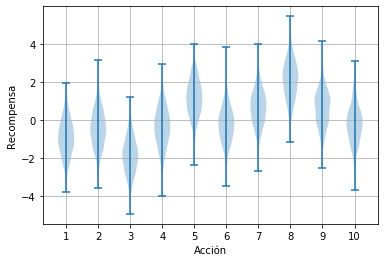

In [301]:
import matplotlib.pyplot as plt

r = [sorted(np.random.normal(q[a], 1, 1000)) for a in q]
plt.violinplot(r)
plt.xlabel('Acción')
plt.xticks(range(1,11))
plt.ylabel('Recompensa')
plt.grid(True)
plt.show()

Ahora generaremos un número elevado de entornos y calcularemos la recompensa media obtenida a lo largo del entrenamiento para diferentes valores de $\epsilon$ 

In [321]:
ejecuciones = 2000
experiencias = 1000
epsilons = [0, 0.01, 0.1]
recompensas_medias = np.zeros((len(epsilons), experiencias))
acciones_optimas = np.zeros((len(epsilons), experiencias))

for ej in range(ejecuciones):
    q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 10))} 
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,11)}
        acciones = {k: 0 for k in range(1,11)}
        recompensas = {k: 0 for k in range(1,11)}
        for exp in range(experiencias):
            # elegir acción
            if np.random.uniform(0,1) < e:
                # acción aleatoria
                a = np.random.randint(10) + 1
            else:
                # acción con mayor valor
                maxQ = -100
                for j in range(1, 11):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            acciones[a] += 1
            recompensa = np.random.normal(q[a], 1, 1)
            recompensas[a] += recompensa
            Q[a] = recompensas[a]/acciones[a]
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)
            
recompensas_medias /= ejecuciones
acciones_optimas /= ejecuciones

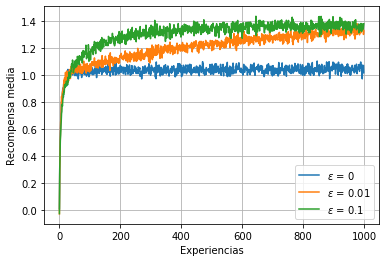

In [322]:
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

Como podemos ver un método *greedy* se queda encallado con la primera acción buena que encuentra, mientras que si le dejamos posibilidad de explorar es posible que encuentre nuevas acciones que den como resultado mayores recompensas a largo plazo.

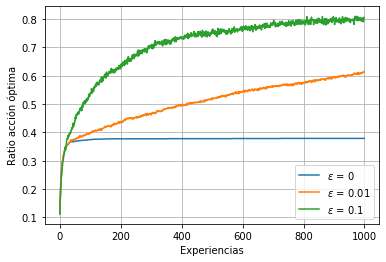

In [323]:
for i, e in enumerate(epsilons):
    plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

Un valor bajo de $\epsilon$ converge más lento, pero eventualmente superaría al valor grande. Una técnica muy usada consiste en ir reduciendo el valor de $\epsilon$ durante el entrenamiento, así podemos explorar un gran espacio de acciones al principio y enfocarnos en explotar acciones buenas al final.

La eficacia de usar un valor de $\epsilon > 0$ dependerás del caso. En casos con una variancia en las recompensas elevada necesitaremos más exploración, por lo que podemos esperar todavía mejor resultado que sin exploración. Por otro lado, si la variancia fuese 0, un método *greedy* podría encontraría el valor óptimo solo con probar cada acción una vez. Aún así, usar $\epsilon > 0$ suele dar mejor resultado.

## Implementación incremental

Vamos a ver como calcular los valores promedios necesarios para estimar los valores de las acciones de manera más eficiente. En la implementación anterior hemos ido guardando la recompensa obtenida al realizar cada acción, así como el número de veces que una acción se lleva a cabo, para calcular el valor de la acción. Sin embargo podemos obtener el mismo resultado con un método incremental.

\begin{equation}
    Q_{n+1} = Q_n + \frac{1}{n} [R_n - Q_n]
\end{equation}

Esta fórmula se repite a menudo en el axr, y generalmente toma la siguiente forma

\begin{equation}
    \text{nuevo valor} \leftarrow \text{viejo valor} + \text{ratio de cambio} \, [\text{valor objetivo}-\text{viejo valor}]
\end{equation}

In [448]:
ejecuciones = 2000
experiencias = 1000
epsilons = [0, 0.01, 0.1]
recompensas_medias = np.zeros((len(epsilons), experiencias))
acciones_optimas = np.zeros((len(epsilons), experiencias))

for ej in range(ejecuciones):
    q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 10))} 
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,11)}
        for exp in range(experiencias):
            # elegir acción
            if np.random.uniform(0,1) < e:
                # acción aleatoria
                a = np.random.randint(10) + 1
            else:
                # acción con mayor valor
                maxQ = -100
                for j in range(1, 11):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            recompensa = np.random.normal(q[a], 1, 1)
            Q[a] += (recompensa - Q[a])/(exp+1)
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)
            
recompensas_medias /= ejecuciones
acciones_optimas /= ejecuciones

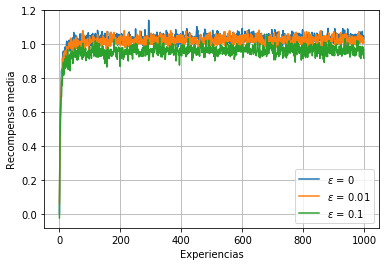

In [449]:
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

## Problemas no estacionarios

En un problema no estacionario la recompensa obtenida al llevar a cabo una acción puede variar en el tiempo. En estos casos tiene sentido dar mayor importancia a las recompensas más recientes. La forma más apropiada de hacer esto es usar un ratio de cambio constante.

\begin{equation}
    Q_{n+1} = Q_n + \alpha [R_n - Q_n]
\end{equation}

donde $\alpha \in (0, 1]$ es una constante. 

In [416]:
def run(ejecuciones = 2000, experiencias = 1000, epsilons = [0.1], alpha=0.1):    
    recompensas_medias = np.zeros((len(epsilons), experiencias))
    acciones_optimas = np.zeros((len(epsilons), experiencias))
    for ej in range(ejecuciones):
        for i, e in enumerate(epsilons):
            # inicializamos los valores óptimos al mismo valor
            q = {k: 1 for k in range(1,11)} 
            Q = {k: 0 for k in range(1,11)}
            for exp in range(experiencias):
                # variar q de manera aleatoria
                q = {k: q[k] + np.random.normal(0, 0.01, 1)[0] for k in q}
                mejor_accion = max(q, key=q.get)
                # elegir acción
                if np.random.uniform(0,1) < e:
                    # acción aleatoria
                    a = np.random.randint(10) + 1
                else:
                    # acción con mayor valor
                    maxQ = -100
                    for j in range(1, 11):
                        if Q[j] > maxQ:
                            maxQ = Q[j]
                            a = j
                recompensa = np.random.normal(q[a], 1, 1)
                Q[a] += alpha*(recompensa - Q[a])
                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= ejecuciones
    acciones_optimas /= ejecuciones
    
    return recompensas_medias, acciones_optimas

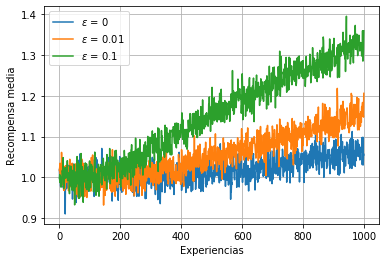

In [417]:
epsilons = [0, 0.01, 0.1]
recompensas_medias, acciones_optimas = run(epsilons=epsilons)

for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

## Valores iniciales optimistas

Los métodos vistos hasta ahora dependían de las estimaciones iniciales $Q_1(a)$. Esto nos introduce un *bias* que implica que en la práctica la inicialización se convierte en un hiperparámetro más que el ususario debe escoger. Podemos usar este hecho en nuestra ventaja. Si inicializamos los valores de las acciones por encima de sus valores reales, nuestro agente intentrá llevar a cabo estas acciones, y enseguida las descartará ya que la recompensa obtenida será menor y por lo tanto su valor disminuirá. Esto implica que includo un agente $greedy$ probará todas las acciones antes de quedarse con una, habiendo explorado.

In [418]:
ejecuciones = 2000
experiencias = 1000
alpha=0.1
epsilons = [0, 0.1]
recompensas_medias = np.zeros((len(epsilons), experiencias))
acciones_optimas = np.zeros((len(epsilons), experiencias))

for ej in range(ejecuciones):
    q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 10))} 
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,11)}
        # inicializamos a valores altos si el agente es greedy
        if e == 0:
            Q = {k: 5 for k in range(1,11)}
        for exp in range(experiencias):
            # elegir acción
            if np.random.uniform(0,1) < e:
                # acción aleatoria
                a = np.random.randint(10) + 1
            else:
                # acción con mayor valor
                maxQ = -100
                for j in range(1, 11):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            recompensa = np.random.normal(q[a], 1, 1)
            Q[a] += alpha*(recompensa - Q[a])
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)
            
recompensas_medias /= ejecuciones
acciones_optimas /= ejecuciones

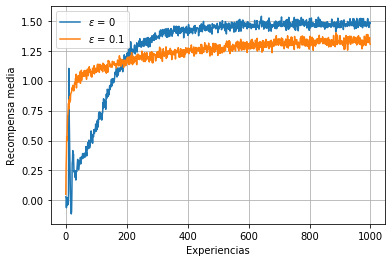

In [419]:
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

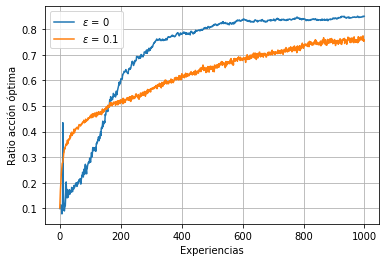

In [420]:
for i, e in enumerate(epsilons):
    plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

Esta técnica funciona bien en problemas estacionarios, pero si el problema no es estacionario y las recompensas van cambiando durante el tiempo tendremos el mismo problema que antes con un agente que no explora. Este problema es común para cualquier método enfocado en la inicialización.

## Selección de acciones con intervalo de confianza

El método $\epsilon-greedy$ basa la exploración en escoger acciones aleatorias sin ningun tipo de preferencia, pero una mejor forma de hacerlo es escogiendo aquellas acciones menos exploradas con mayor potencial.


\begin{equation}
    A_t = \underset{a}{\arg\max} \, \left[ Q_t(a) + c \sqrt{\frac{\text{ln} \, t}{N_t(a)}} \right]
\end{equation}

donde $\text{ln} \, t$ es el logaritmo natural de $t$, $N_t(a)$ es el número de veces que se has efectuado la acción $a$ y $c > 0$ es una constante que controla el ratio de exploración.

In [452]:
import math

ejecuciones = 2000
experiencias = 1000
alpha=0.1
c = 2
epsilons = [0, 0.1]
recompensas_medias = np.zeros((len(epsilons), experiencias))
acciones_optimas = np.zeros((len(epsilons), experiencias))

for ej in range(ejecuciones):
    q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 10))} 
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,11)}
        acciones = {k: 0 for k in range(1,11)}
        for exp in range(experiencias):
            if e == 0: # UCB si el agente es greedy
                maxQ = -100
                for j in range(1, 11):
                    A = Q[j] + c*math.sqrt(math.log(exp+1)/(acciones[j]+1e-8))
                    if A > maxQ:
                        maxQ = A
                        a = j
            else:
                # elegir acción
                if np.random.uniform(0,1) < e:
                    # acción aleatoria
                    a = np.random.randint(10) + 1
                else:
                    # acción con mayor valor
                    maxQ = -100
                    for j in range(1, 11):
                        if Q[j] > maxQ:
                            maxQ = Q[j]
                            a = j
            acciones[a] += 1
            recompensa = np.random.normal(q[a], 1, 1)
            Q[a] += alpha*(recompensa - Q[a])
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)
            
recompensas_medias /= ejecuciones
acciones_optimas /= ejecuciones

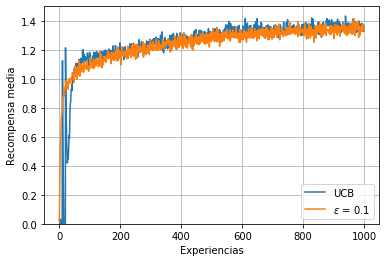

In [455]:
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}' if e is not 0 else "UCB")
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.ylim([0,1.5])
plt.show()

Si bien esta técnica funciona mejor para este problema, su uso no está muy generalizado ya que no es fácil de integrar en problemas de axr con grandes espacios de búsqueda o preblemas no estacionarios.

## Algoritmos de Gradiente

Hasta el momento sólo hemos considerado métodos que estiman el valor de las acciones y utilizan estas estimaciones para seleccionar la acción que ejecutar en cada momento. Sin embargo, existen otras alternativas, como asignar una ^*preferencia* a cada acción $H_t(a)$. Cuanta mayor sea la preferncia de una acción, más veces será ejecutada. Podemos definir $\pi_t(a)$ como la probabilidad de escoger la acción $a$ en el instante $t$

\begin{equation}
    \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}
\end{equation}

Existe un algoritmo para entrenar un agente bajo estas condiciones basado en la idea de ascenso por gradiente.

\begin{equation}
    \begin{array}{ll}
        H_{t+1}(a) = H_{t}(a) + \alpha(R_t-\tilde{R_t})(1-\pi_t(A_t)) & \text{and} \\
        H_{t+1}(a) = H_{t}(a) - \alpha(R_t-\tilde{R_t})\pi_t(a) & \text{for all } a \neq A_t
    \end{array}
\end{equation}

donde $\tilde{R_t}$ es el promedio de todas las recompensas hasta el instante $t$ (incluído). Este valor actúa como referencia con la que comparamos la recompensa. Si es mayor, la probabilidad de escoger esa acción en el futuro aumenta. Si es menos, la probabilidad se reduce. Las acciones no escogidas, se actualizan en el sentido opuesto.


In [504]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [557]:
ejecuciones = 2000
experiencias = 1000
alphas = [0.1, 0.4]
recompensas_medias = np.zeros((len(epsilons), experiencias))
acciones_optimas = np.zeros((len(epsilons), experiencias))
for ej in range(ejecuciones):
    q = {k+1: v for k, v in enumerate(np.random.normal(4, 1, 10))} 
    mejor_accion = max(q, key=q.get)
    for i, alpha in enumerate(alphas):
        H = np.zeros(10)
        pi = softmax(H)
        recompensas = []
        for exp in range(experiencias):
            # elegir acción
            a = np.random.choice(range(1,11),1,p=pi)[0]            
            recompensa = np.random.normal(q[a], 1, 1) 
            recompensas.append(recompensa)
            recompensa_media = np.mean(recompensas)
            # actualizar preferencias
            for j in range(10):
                if j == a-1:
                    H[j] += alpha*(recompensa - recompensa_media)*(1-pi[j])
                else:
                    H[j] -= alpha*(recompensa - recompensa_media)*pi[j]        
            # actualizar probabilidades
            pi = softmax(H)
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)
            
recompensas_medias /= ejecuciones
acciones_optimas /= ejecuciones

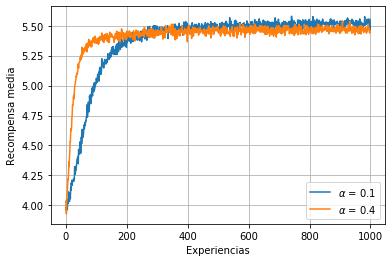

In [558]:
for i, a in enumerate(alphas):
    plt.plot(recompensas_medias[i], label=fr'$\alpha$ = {a}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

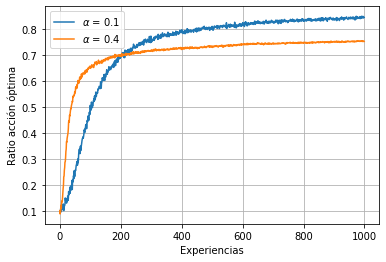

In [559]:
for i, a in enumerate(alphas):
    plt.plot(acciones_optimas[i], label=fr'$\alpha$ = {a}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

## Búsqueda asociativa

Hasta ahora solo hemos tratado con tareas no asociativas, tareas en las que no es necesario asociar diferentes acciones a diferentes situaciones. Sin embargo, en una tarea de axr general existen más de una situación y el objetivo es aprender una *política*: una relación entre situaciones y las mejores acciones que llevar a cabo en esa situación. Una tarea asociativa require de prueba y error para encontrar las mejores acciones y poder asociarlas a las situaciones correspondientes. 

## Resumen

Hemos visto algunos ejemplos sencillos para balancear la exploración y la explotación, con algoritmos $\epsilon-greedy$ que escogen acciones aleatorias de vez en cuando y algoritmos $UCB$ que favorecen en cada instante acciones que han sido ejecutadas muchas veces. Los algoritmos de gradiente no estiman valores, sino prefencias, y favorecen aquellas acciones más probables utilizando una distribución softmax. También hemos visto brevemente como la inicialización puede favorecer la exploración the un método $greedy$.